# Utilities

In [1]:
%gui wx
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, DownloadProgressBar, download_url, direct_file_download_open_neuro, get_json_from_file
os.environ["DIPY_HOME"] = "./data/"
loadFSL()
import fsl.wrappers
from fsl.wrappers import fslmaths, mcflirt
import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
import mne
import mne_nirs
import shutil
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import requests
import urllib.request
from tqdm import tqdm
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
import glob
import pandas as pd
import numpy as np
import json
import subprocess
import matplotlib.pyplot as plt
import os
import sys

sys.stderr = open(os.devnull, 'w')
os.environ['G_DEBUG'] = 'fatal-warnings'

In [2]:
%load_ext autoreload
%autoreload 2
from utilities import get_skull_stripped_anatomical, apply_python_mask_approach, launch_freeview, fsl_anat_wrapped, load_mot_params_fsl_6_dof, compute_FD_power, apply_transform, combine_all_transforms, normalize_fMRI,run_subprocess, merge_to_mni, smooth_volume, normalize_fMRI_mean_std, normalize_fMRI_minmax

In [3]:
%%capture
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [4]:
display = True

In [14]:
number = 3

# Folders

In [15]:
dataset_id = 'ds000171' 
subject_id = f'control0{number}'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives') 
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(bids_root, exist_ok=True)
subject_dir = 'sub-{}'.format(subject_id)
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

In [16]:
anatomical_path = op.join(bids_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w.nii.gz')
betted_brain_path = op.join(preproc_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w.nii.gz') 
resulting_mask_path = op.join(preproc_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w_mask.nii.gz') 
segmentation_path = op.join(preproc_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w_fast')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
flirt_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt_matrix_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_lin.mat'.format(subject_id))
ants_t1_mni_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN'.format(subject_id))
ants_t1_mni_path_warp = ants_t1_mni_path+"_warp.nii.gz"


functional_concatenated= op.join(preproc_root,f"sub-control0{number}/func", f'sub-control0{number}_task-music_concat_bold.nii.gz')
path_moco_data = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_moco')

## Download

In [24]:
%%capture
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, 
                "--target-dir", bids_root, 
                "--include", op.join(subject_dir, '*'),    
               ], check=False) 
os.makedirs(op.join(bids_root, 'derivatives'), exist_ok=True)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(op.join(preproc_root, subject_dir), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'anat'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'func'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'fmap'), exist_ok=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …
Cannot determine local revision of the dataset, and the target directory is not empty. If the download fails, you may want to try again with a fresh (empty) target directory.
  Request timed out while fetching metadata, retrying …
  Request timed out while fetching metadata, retrying …
📥 Retrieving up to 15 files (5 concurrent downloads). 
✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


In [30]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(anatomical_path) 

## Skull stripping

In [22]:
get_skull_stripped_anatomical(bids_root, preproc_root, f"control0{number}", robust=True)

Done with BET.


In [23]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(anatomical_path)
    fsleyesDisplay.load(resulting_mask_path)

In [24]:
apply_python_mask_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [ ]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(betted_brain_path)

## Tissue segmentation

In [25]:
[os.remove(f) for f in glob.glob(op.join(preproc_root, f'sub-control0{number}', 'anat', '*fast*'))]
fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3);

Let's check the quality of the segmentation, shall we?
We want to extract 3 tissue types here: the white matter, the grey matter and the csf. How well did fast perform?

In [ ]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|--------------- sub-control01_T1w_mni_SyN_warp.nii.gz
|--------------- sub-control01_T1w_mni_leastsq.nii.gz
|--------------- sub-control01_T1w_mni_lin.mat
|--------------- sub-control01_T1w_mni_normcorr.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_concat_bold.nii.gz
|--

The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)


Display colors
- pve_0 in <span style="color:red;">red</span>
- pve_1 in <span style="color:green;">green</span>
- pve_2 in <span style="color:blue;">blue</span>

In [ ]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(betted_brain_path)
    # CSF
    fsleyesDisplay.load(glob.glob(op.join(preproc_root, f'sub-control0{number}', 'anat','*pve_0*'))[0])
    # GM
    fsleyesDisplay.load(glob.glob(op.join(preproc_root, f'sub-control0{number}', 'anat','*pve_1*'))[0])
    # WM
    fsleyesDisplay.load(glob.glob(op.join(preproc_root, f'sub-control0{number}', 'anat','*pve_2*'))[0])

    fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
    fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
    fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'


# Coregistration MNI-T1

### Linear normalization

In [26]:
flirt(betted_brain_path, mni_template, out=flirt_path, omat = flirt_matrix_path)

{}

Visualize the result of flirt on top of the reference. What do you think of alignment?

In [40]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(mni_template) 
    fsleyesDisplay.load(flirt_path)

Which cost should we use? If you were in a pure void, there would be no right or wrong answer from the get-go. No choice but to experiment and find out!

Hopefully, <a href="https://fsl.fmrib.ox.ac.uk/fsl/docs/#/registration/flirt/user_guide?id=flirt">the documentation</a> should give you some pointers. What you want here is to register a T1 to a T1: this is a <u>within</u> modality registration, so you should restrict yourself only to costs appropriate to this type of modality! 

To help you, we've set up a cell that will run the different coregistrations for you. Simply fill in the different costs to consider :)

In [18]:
possible_costs = ['mutualinfo', 'corratio', 'normcorr', 'normmi', 'leastsq', 'labeldiff']
costs_to_consider = ['leastsq', 'normcorr'] 
# FIXME: ISSUE WITH THE LEASTSQ COST RESULT

In [19]:
for c in costs_to_consider:
    flirt(betted_brain_path, mni_template, out=flirt_path + '_' + c, cost=c)


Final result: 
3.458371 1.648305 3.627273 -990.534765 
-2.861950 1.235282 4.578044 -54.943603 
0.433791 -5.372595 2.300280 588.875671 
0.000000 0.000000 0.000000 1.000000 


Final result: 
0.003107 0.005315 -1.116440 204.932830 
-0.935071 0.500262 0.007008 178.944986 
0.501467 1.049276 -0.004127 -149.788866 
0.000000 0.000000 0.000000 1.000000 



In [20]:
if display:
    for c in costs_to_consider:
        fsleyesDisplay.load(flirt_path + '_' + c)

## Non linear normalization

*FNIRT does NOT expect the input data to be skull-stripped.*

In [9]:
moving_image = ants.image_read(betted_brain_path)
fixed_image = ants.image_read(mni_template + '.nii.gz')
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
ants.image_write(warpedImage, ants_t1_mni_path + '.nii.gz')
warp_field = ants.image_read(transformation['fwdtransforms'][0])
nifti_warp_field = nib.Nifti1Image(warp_field.numpy(), affine=nib.load(transformation['fwdtransforms'][0]).affine)
nib.save(nifti_warp_field, ants_t1_mni_path_warp)

Look at the results and compare it against the linear coregistration. Which one do you prefer? Why?

In [37]:
if display:

    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(mni_template)
    fsleyesDisplay.load(betted_brain_path)
    fsleyesDisplay.load(ants_t1_mni_path + '.nii.gz')
    fsleyesDisplay.load(ants_t1_mni_path_warp)

# Volume removal


In [ ]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-2_bold.nii.gz'))

### Field stabilization

In [27]:
os.listdir(op.join(bids_root, f'sub-control0{number}', 'func'))

['sub-control03_task-music_run-3_events.tsv',
 'sub-control03_task-music_run-4_events.tsv',
 'sub-control03_task-music_run-3_bold.nii.gz',
 'sub-control03_task-music_run-4_bold.nii.gz',
 'sub-control03_task-music_run-5_events.tsv',
 'sub-control03_task-music_run-5_bold.nii.gz',
 'sub-control03_task-nonmusic_run-1_bold.nii.gz',
 'sub-control03_task-nonmusic_run-2_events.tsv',
 'sub-control03_task-nonmusic_run-1_events.tsv',
 'sub-control03_task-nonmusic_run-2_bold.nii.gz']

Text(0, 0.5, 'Mean voxel intensity')

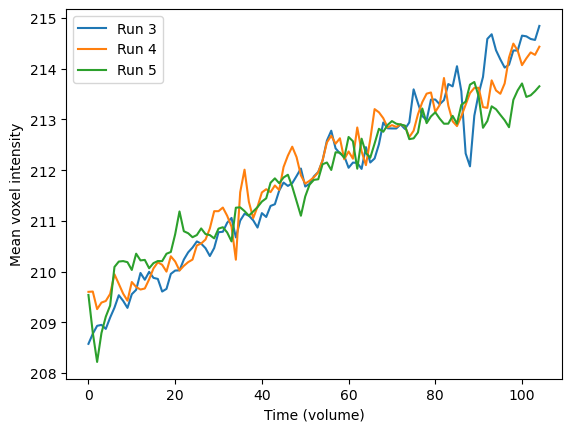

In [30]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(3,6):
    bold_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold.nii.gz')
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [31]:
import matplotlib.pyplot as plt
import nibabel as nib


<h3>Correction of slice 17 in second run</h3>

In [32]:
functional_2_path = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold.nii.gz')

In [33]:
img = nib.load(functional_2_path)
data = img.get_fdata()
data[:, :, 47, 17] = data[:, :, 46, 17]
img_out = nib.Nifti1Image(data,img.affine, img.header)
nib.save(img_out, op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold.nii.gz'))

Text(0, 0.5, 'Mean voxel intensity')

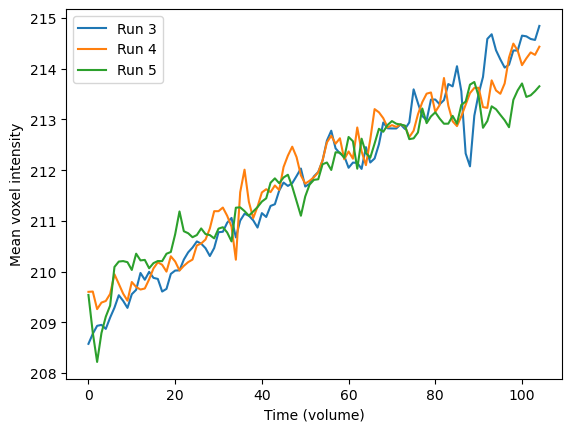

In [31]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(3,6):
    bold_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold.nii.gz')
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [33]:
for run in range(3,6):
    bold_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold.nii.gz')
    out_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold_norm.nii.gz')
    normalize_fMRI_mean_std(bold_path, out_path)


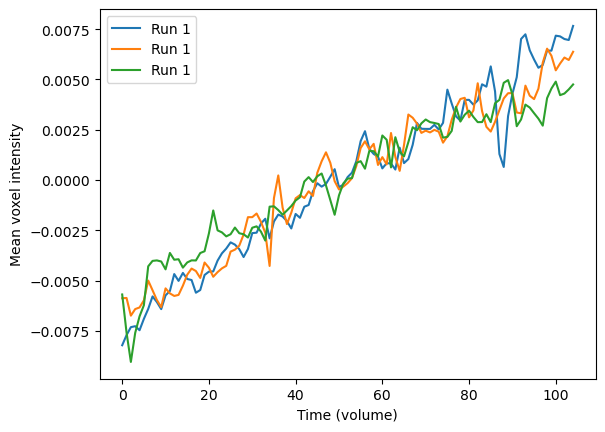

In [34]:
for run in range(3,6):
    out_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold_norm.nii.gz')
    plt.plot(nib.load(out_path).get_fdata().mean(axis=(0,1,2)), label='Run 1')

plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.legend()
plt.show()

<h2>Concatenation of data</h2>

In [35]:
data = []
aff = []
headers = []
for run in range(3,6):
    out_path = op.join(bids_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_run-{run}_bold_norm.nii.gz')
    img = nib.load(out_path)
    aff.append(img.affine)
    headers.append(img.header)
    img = img.get_fdata()
    print(img.shape)
    data.append(img)
data = np.concatenate((data), axis = 3)

(80, 80, 50, 105)
(80, 80, 50, 105)
(80, 80, 50, 105)


In [36]:
img_out = nib.Nifti1Image(data,aff[0],headers[0])
nib.save(img_out, functional_concatenated)

In [57]:
if display:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(functional_concatenated)

## Motion correction

In [37]:
mcflirt(
    infile=functional_concatenated,  # The input file (original BOLD data)
    o=path_moco_data,           # The output file (motion-corrected data)
    plots=True,                 # Generate plots for visualizing motion correction.
    report=True,                # Generate a report on the motion correction process.
    dof=6,                      # Set degrees of freedom to 6 for rigid-body transformation.
    mats=True                   # Save the transformation matrices.
)

refnum = 157
Original_refvol = -1


{}

In [41]:
if True:
    fsleyesDisplay.resetOverlays() 
    fsleyesDisplay.load(functional_concatenated)
    fsleyesDisplay.load(path_moco_data) 

The motion parameters are stored in the .par file produced by MCFLIRT. Notice that since each volume moved differently, we have one transformation per volume, thus one set of motion parameters per volume as well. We provide you with a way to load these parameters:

In [38]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_moco.par')) 
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.004329,0.001285,-0.004073,-0.114716,0.085176,0.204557
1,-0.005123,0.001128,-0.003870,-0.118333,0.127714,0.233086
2,-0.005445,0.001048,-0.003875,-0.118319,0.124049,0.245112
3,-0.005300,0.001110,-0.003887,-0.118336,0.114174,0.209395
4,-0.005514,0.001552,-0.004284,-0.111895,0.153666,0.248530
...,...,...,...,...,...,...
310,-0.003733,-0.000147,0.000524,-0.008971,0.358944,0.344767
311,-0.003719,0.000030,0.000656,-0.017083,0.350994,0.342445
312,-0.003731,0.000030,0.000656,-0.010030,0.346402,0.329971
313,-0.003530,-0.000041,0.000656,0.000147,0.340483,0.332365


Based on **translation on X alone**, can you find perhaps a volume which exceeds with respect to the **preceding volume** a 0.2 mm displacement?

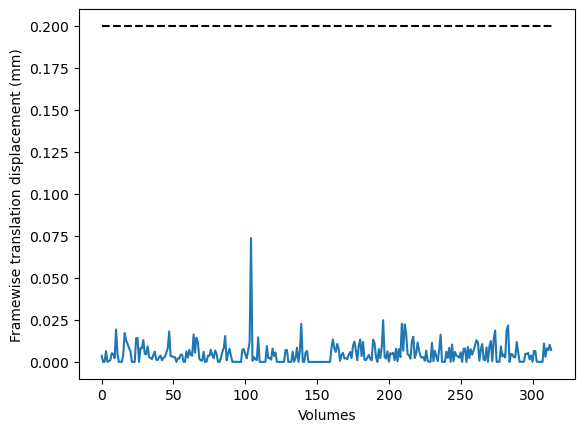

In [39]:
trans_x = mot_params["Translation x"] # Getting the translation on X
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x) # Getting the displacement on X. We use np.diff to calculate the difference between consecutive elements in the translation on X.
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2 
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, len(disp_x),colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

Now, we can use the code below to extract an aggregate measure of motion for all volumes. 

In [40]:
fd = compute_FD_power(mot_params).to_numpy()

In [41]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

In [42]:
import plotly.express as px

fig = px.line(x=list(range(1, fd.size+1)), y=fd, labels={'x': 'Volume', 'y': 'FD displacement (mm)'})
fig.add_hline(y=threshold, line_dash="dash", annotation_text="FD threshold", annotation_position="bottom right")
fig.show()

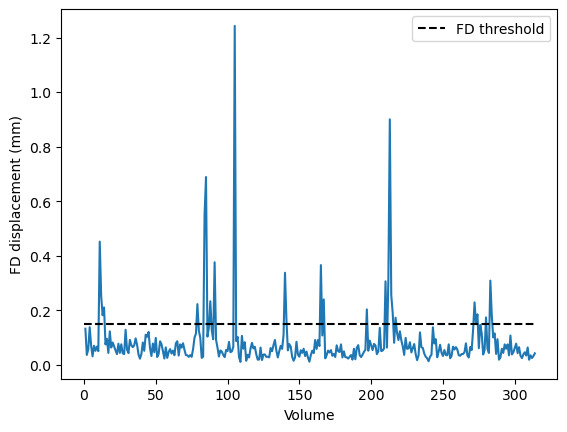

In [43]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, len(fd),colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

Okay great, but what if we want to know which volumes are actually above threshold? Simply run the cell below!

In [44]:
# Volume indices where FD is above the threshold
np.where(fd > threshold)[0] + 1 

array([ 11,  12,  13,  14,  79,  84,  85,  88,  91, 105, 140, 141, 165,
       167, 197, 210, 212, 213, 214, 215, 217, 272, 273, 274, 280, 283,
       284])

In [49]:
#FIXME THERE ARE VOLUMES TO BE REMOVED

# Coregistration of functional to anatomical

In [45]:
from fsl.wrappers import epi_reg


epi_target = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold.nii.gz')
whole_t1 = op.join(bids_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w')
skull_stripped_t1 = op.join(preproc_root, f'sub-control0{number}', 'anat', f'sub-control0{number}_T1w') 
epi_output_path = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_bbr')
ref_vol_name = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_vol_middle') 

In [46]:
mkdir_no_exist(op.join(preproc_root, f'sub-control0{number}', 'func', 'splits',))
split_name = op.join(preproc_root, f'sub-control0{number}', 'func', 'splits',f'sub-control0{number}_task-music_concat_bold_split')
subprocess.run(['fslsplit', epi_target, split_name, '-t'])

CompletedProcess(args=['fslsplit', './data/ds000171/derivatives/preprocessed_data/sub-control03/func/sub-control03_task-music_concat_bold.nii.gz', './data/ds000171/derivatives/preprocessed_data/sub-control03/func/splits/sub-control03_task-music_concat_bold_split', '-t'], returncode=0)

In [47]:
use_single_vol = True

if use_single_vol:

    fslroi(epi_target, ref_vol_name, str(150), str(1))
    
    # Run epi_reg to register the extracted middle EPI volume to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(ref_vol_name),  # The EPI image (middle volume) to be registered.
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(epi_output_path)    # The output path where the registered image will be saved.
    ])
else:
    # If not using a single volume, register the entire motion-corrected EPI series to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(epi_target),    # The full motion-corrected EPI image (all volumes).
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(epi_output_path),    # The output path where the registered image will be saved.
    ])


Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.321521 0.999156 -0.041055 -0.001525 0.000000 0.041077 0.998974 0.019090 0.000000 0.000740 -0.019136 0.999817 0.000000 -6.262769 11.372977 -2.567608 1.000000 


In [74]:
if display:

    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(skull_stripped_t1)
    fsleyesDisplay.load(epi_output_path)

In [48]:
warp_name_linear = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_bbr_linear_combined_warp.nii.gz')
subprocess.run([
    'convertwarp',
    '--ref={}'.format(mni_template),
    '--premat={}'.format(epi_output_path+'.mat'),
    '--postmat={}'.format(flirt_matrix_path),
    '--out={}'.format(warp_name_linear)
])    

CompletedProcess(args=['convertwarp', '--ref=/data/fsl//data/standard/MNI152_T1_1mm_brain', '--premat=./data/ds000171/derivatives/preprocessed_data/sub-control03/func/sub-control03_task-music_concat_bold_bbr.mat', '--postmat=./data/ds000171/derivatives/preprocessed_data/sub-control03/anat/sub-control03_T1w_mni_lin.mat', '--out=./data/ds000171/derivatives/preprocessed_data/sub-control03/func/sub-control03_task-music_concat_bold_bbr_linear_combined_warp.nii.gz'], returncode=0)

In [55]:
from fsl.wrappers import applywarp
out_vol = "test.nii.gz"
applywarp(ref_vol_name,mni_template, out_vol, w=warp_name_linear, rel=False)

{}

In [56]:
if True:
    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(mni_template)
    fsleyesDisplay.load(out_vol)

In [53]:
# moving_image = ants.image_read(ref_vol_name+'.nii.gz')
# fixed_image = ants.image_read(whole_t1+'.nii.gz')
# transformation = ants.registration(
#     fixed=fixed_image, 
#     moving=moving_image, 
#     type_of_transform='SyN'
# )

# # Apply the transformation to the moving image
# warped_image = ants.apply_transforms(
#     fixed=fixed_image, 
#     moving=moving_image, 
#     transformlist=transformation['fwdtransforms']
# )
# resultAnts = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr_SyN.nii.gz')
# ants.image_write(warped_image, resultAnts)
# warp_field_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr_SyN_warp.nii.gz')
# warp_field = ants.image_read(transformation['fwdtransforms'][0])
# nifti_warp_field = nib.Nifti1Image(warp_field.numpy(), affine=nib.load(transformation['fwdtransforms'][0]).affine)
# nib.save(nifti_warp_field, warp_field_path)

In [57]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
fsleyesDisplay.load(flirt_path)
fsleyesDisplay.load(ants_t1_mni_path)


In [ ]:
warp_name_syn = op.join(preproc_root, f'sub-control0{number}', 'func', f'sub-control0{number}_task-music_concat_bold_bbr_SyN_combined_warp.nii.gz')
subprocess.run([
    'convertwarp',
    '--ref={}'.format(mni_template),
    '--premat={}'.format(epi_output_path+'.mat'),
    '--warp1={}'.format(ants_t1_mni_path_warp),
    '--out={}'.format(warp_name_syn)
])    

CompletedProcess(args=['convertwarp', '--ref=/data/fsl//data/standard/MNI152_T1_1mm_brain', '--premat=./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr.mat', '--warp1=./data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mni_SyN_warp.nii.gz', '--out=./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr_SyN_combined_warp.nii.gz'], returncode=0)

In [59]:
from fsl.wrappers import applywarp
out_vol = "test.nii.gz"
applywarp(ref_vol_name,mni_template, out_vol, w=warp_name_syn, rel=False)

{}

Let's overlay the two (EPI and anatomical) on top of each other to visualize the quality of the coregistration!

In [60]:
if True:

    fsleyesDisplay.resetOverlays()
    fsleyesDisplay.load(mni_template)
    fsleyesDisplay.load(ants_t1_mni_path)
    fsleyesDisplay.load(out_vol)

In [49]:
split_std = op.join(preproc_root, f'sub-control0{number}', 'func', 'std')
mkdir_no_exist(split_std)
# Notice that we are sorting the volumes here! This is important, to make sure we don't get them in random order :)
split_dir = op.join(preproc_root, f'sub-control0{number}', 'func', 'splits')
split_vols = sorted([op.join(split_dir, f) for f in os.listdir(split_dir)])


In [52]:
import concurrent.futures
from tqdm import tqdm

# Initialize ThreadPoolExecutor and the progress bar
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # Use tqdm to wrap the futures
    with tqdm(total=len(split_vols)) as progress:
        # Launch subprocesses in parallel
        futures = {executor.submit(run_subprocess, preproc_root,mni_template,warp_name_linear, vol,i,number): vol for i,vol in enumerate(split_vols)}

        # Process completed tasks
        for future in concurrent.futures.as_completed(futures):
            out_vol, vol_nbr = future.result()  # Get the result of the subprocess
            progress.update(1)

## Smoothing

In [53]:
smooth_folder = op.join(preproc_root, f'sub-control0{number}', 'func', 'smoothed')
mkdir_no_exist(smooth_folder)
files = sorted([f.replace(".nii.gz", "") for f in os.listdir(split_std)])

In [54]:
import concurrent.futures
from tqdm import tqdm


# Initialize ThreadPoolExecutor and the progress bar
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # Use tqdm to wrap the futures
    with tqdm(total=len(files)) as progress:
        # Launch subprocesses in parallel
        futures = [executor.submit(smooth_volume, op.join(split_std,f), op.join(smooth_folder,f)) for f in files]

        # Process completed tasks
        for future in concurrent.futures.as_completed(futures):
            future.result()  # Get the result of the subprocess
            progress.update(1)